# Capstone Final

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import os
from time import time
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
import glob
from tqdm import tqdm
import re
import fnmatch

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [15]:
# Changing work directory 
import os
os.chdir('/Volumes/Transcend/Capstone/Working Files')

#creating a list with all data files for all subjects
files = glob.glob('../D1NAMO/**/*.csv',recursive=True)

# files Identifications
signals = ['glucose','Breathing','ECG','Accel','Summary']


# file path construction
x = os.path.join('*dia**/'+'00'+'2'+'/sensor_data/'+'*'+signals[-1]+'.csv')
# check our path
print (x)
print ('_______________________________________________________________________________________________________________')
print('')
path= [file for file in files if fnmatch.fnmatch(file,x)]
import pprint
pprint.pprint (path)

*dia**/002/sensor_data/*Summary.csv
_______________________________________________________________________________________________________________

['../D1NAMO/diabetes_subset/002/sensor_data/2014_10_01-12_35_54/2014_10_01-12_35_54_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_01-20_29_57/2014_10_01-20_29_57_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_02-06_44_21/2014_10_02-06_44_21_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_03-06_33_20/2014_10_03-06_33_20_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_03-14_06_08/2014_10_03-14_06_08_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_04-07_01_03/2014_10_04-07_01_03_Summary.csv',
 '../D1NAMO/diabetes_subset/002/sensor_data/2014_10_04-17_43_12/2014_10_04-17_43_12_Summary.csv']


In [11]:
def Patient_Data(Patient_number):   
    
    import warnings
    warnings.filterwarnings("ignore")

    def Summary_readings():    
    
#         t0=time()

        summary = pd.DataFrame()

        for i in [1,2,3,4,5,6,7,8,9]:

            x = os.path.join('*dia**/'+'00'+str(i)+'/sensor_data/'+'*'+signals[-1]+'.csv')
            path= [file for file in files if fnmatch.fnmatch(file,x)]

            #read all glucose files for all diabetic subjects
            summ_patient = pd.concat([pd.read_csv(file) for file in path],axis=0)
            summ_patient['patient']=i
            summary = summary.append(summ_patient)

        ## convert the time column to be the index

        summary['Time'] = pd.to_datetime(summary['Time'],format='%d/%m/%Y %H:%M:%S.%f')
        summary['Time'] = summary['Time'].astype('datetime64[s]')
        summary = summary.set_index(summary['Time'])
        summary.drop(columns =['Time'],inplace=True)
#         print("done in %0.3fs" % (time() - t0))

        return summary
    
    summary = Summary_readings()    
    summary_patient = summary[summary.patient==Patient_number]
    
    x = os.path.join('*dia**/'+'**/'+'glucose'+'.csv')

    #read all glucose files for all diabetic subjects
    glucoses = [pd.read_csv(file).drop(['type','comments'],axis=1) for file in files if fnmatch.fnmatch(file,x)]


    #Identify patient by adding a column with subject number staring from 1 to 9
    for i,glu in enumerate(glucoses):
        glu['patient'] = np.ones(glu.shape[0])*(i+1) 

    # glucoses: adding differntiation column
    for glu in glucoses:
        glu['glucose_diff'] = glu.glucose.diff()

    glucose = pd.concat(glucoses,axis = 0 )
    glucose['time'] = glucose.pipe(lambda x : pd.to_datetime(x['date']+' '+x['time']))    
    glucose.drop(columns=['date'],inplace=True)
    glucose['bin_number']= glucose.index
    glucose.index = glucose['time']
    glucose.drop(columns=['time'],inplace=True)
    
    try:
        glucose_patient = glucose.iloc[glucose.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')
    
    except:
        x=glucose[glucose['patient']==Patient_number]
        x1=x[x.index.value_counts()>1].reset_index().drop_duplicates(subset='time', keep='first')
        x1.set_index('time',inplace=True)
        x2=x[x.index.value_counts()<2]
        x3=pd.concat([x2,x1],axis=0,sort=True)
        x3.sort_index(inplace=True)
        glucose_patient = x3.iloc[x3.reset_index().groupby('patient').groups[Patient_number]].resample('1s').fillna(method='ffill')

    the_join= glucose_patient.join(summary_patient,lsuffix='g',rsuffix='s',how='inner')
    
    return the_join

CPU times: user 22.5 s, sys: 6.78 s, total: 29.3 s
Wall time: 37.2 s


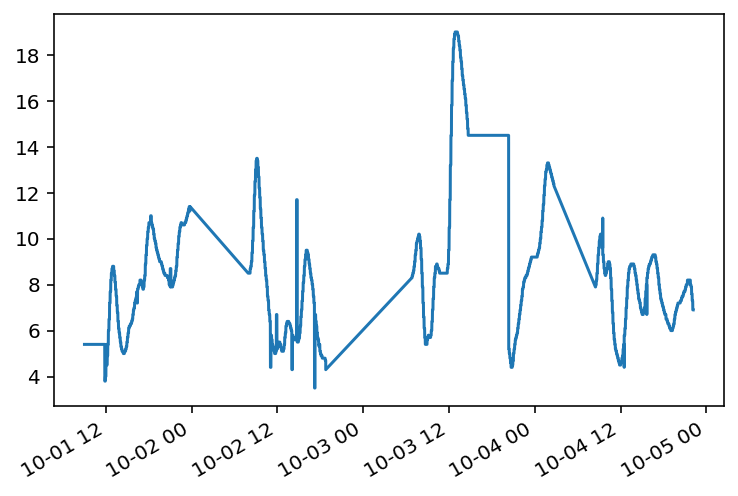

In [14]:
%%time
p=Patient_Data(7)
p.glucose.plot()

In [6]:
def daily_glucose(Patient_number, day):
    
    p=Patient_Data(Patient_number)
    
    day_times={1:['2014-10-01 00:00:00','2014-10-01 06:00:00','2014-10-01 12:00:00','2014-10-01 18:00:00','2014-10-01 23:59:59'],
               2:['2014-10-02 00:00:00','2014-10-02 06:00:00','2014-10-02 12:00:00','2014-10-02 18:00:00','2014-10-02 23:59:59'],
               3:['2014-10-03 00:00:00','2014-10-03 06:00:00','2014-10-03 12:00:00','2014-10-03 18:00:00','2014-10-03 23:59:59'],
               4:['2014-10-04 00:00:00','2014-10-04 06:00:00','2014-10-04 12:00:00','2014-10-04 18:00:00','2014-10-04 23:59:59']
              }

    
    
    fig, ax = plt.subplots(2,2,figsize=(16,8))

    morning=p.loc[day_times[day][1]:day_times[day][2]]
    y1=morning.glucose
    x1=morning.index
    ax[0,0].plot(x1,y1, color="mediumseagreen")
    ax[0,0].legend()
    ax[0,0].set_title('Morning')

    noon=p.loc[day_times[day][2]:day_times[day][3]]
    y2=noon.glucose.values
    x2=noon.index
    ax[0,1].plot(x2,y2, color="mediumseagreen")
    ax[0,1].legend()
    ax[0,1].set_title('Noon')

    night=p.loc[day_times[day][3]:day_times[day][4]]
    y3=night.glucose.values
    x3=night.index
    ax[1,0].plot(x3,y3, color="mediumseagreen")
    ax[1,0].legend()
    ax[1,0].set_title('Night')

    sleeping=p.loc[day_times[day][0]:day_times[day][1]]
    y4=sleeping.glucose.values
    x4=sleeping.index
    ax[1,1].plot(x4,y4, color="mediumseagreen")
    ax[1,1].legend()
    ax[1,1].set_title('Sleeping')

    plt.show()
    
    return p


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


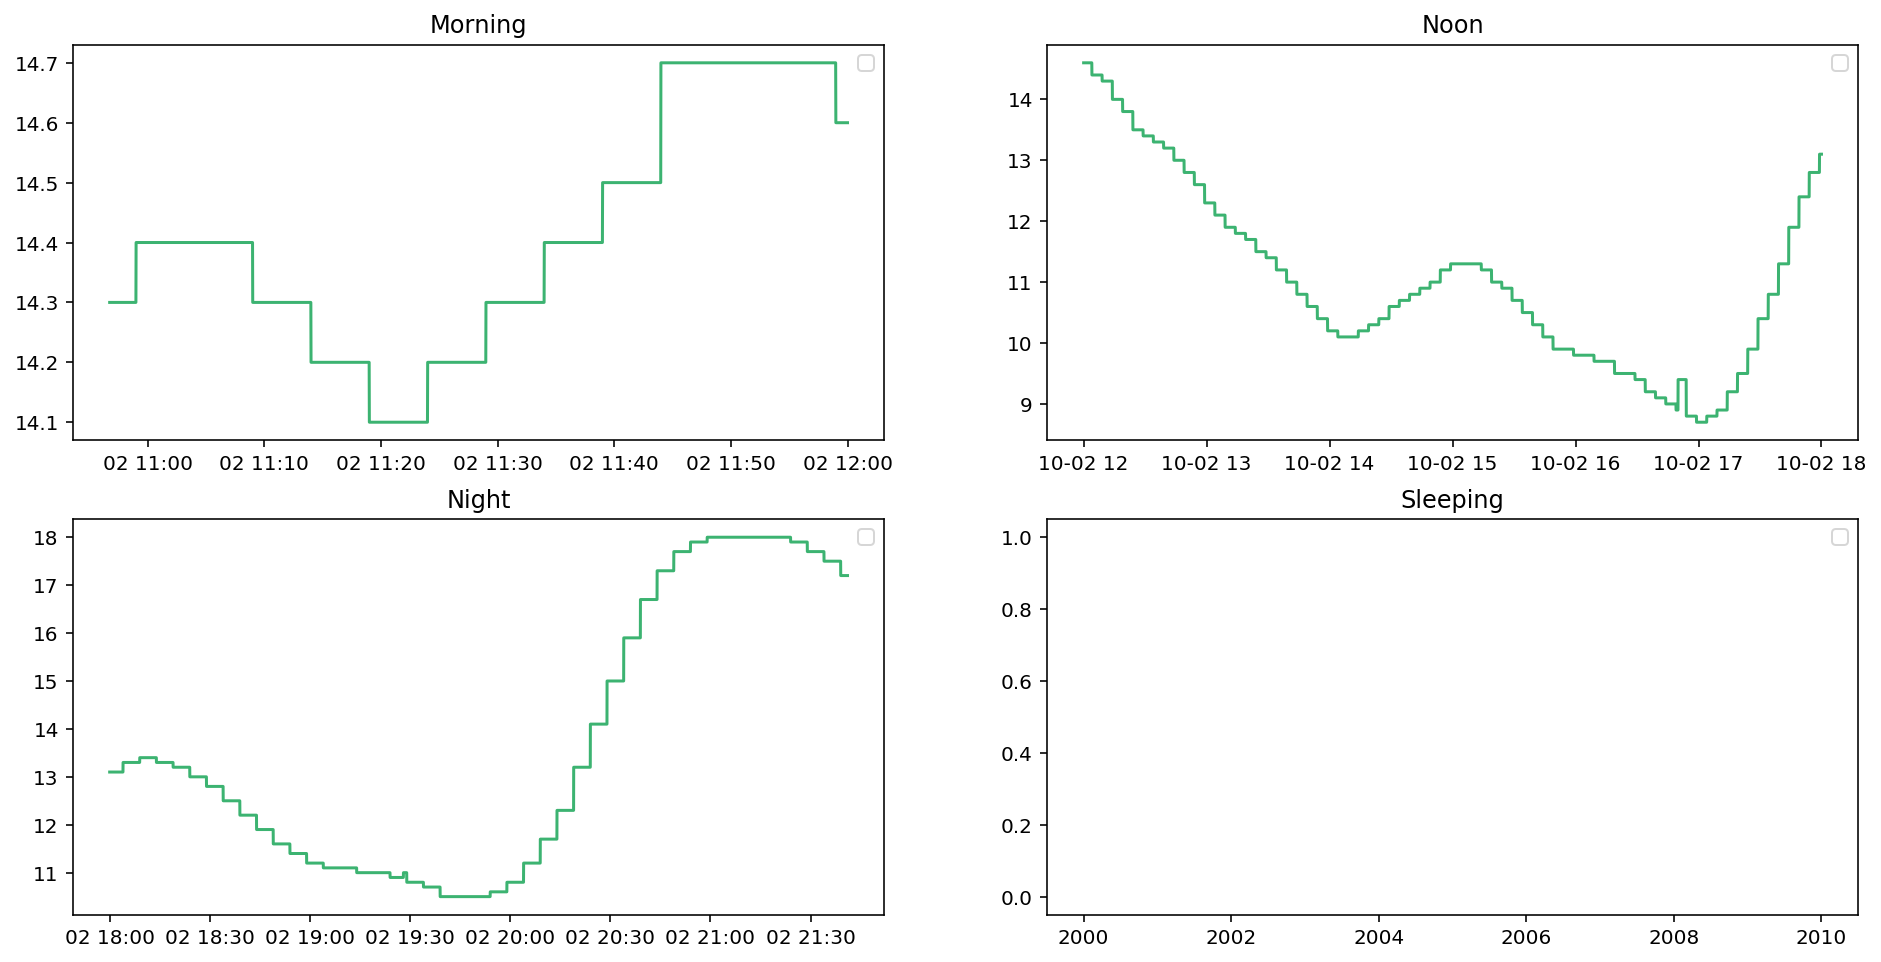

CPU times: user 26.2 s, sys: 6.71 s, total: 32.9 s
Wall time: 35.7 s


,glucose,patientg,glucose_diff,HR,BR,SkinTemp,Posture,Activity,PeakAccel,BatteryVolts,...,DeviceTemp,StatusInfo,LinkQuality,RSSI,TxPower,CoreTemp,AuxADC1,AuxADC2,AuxADC3,patients
2014-10-01 19:14:00,10.3,1.0,NaN,68,21.5,-3276.8,-35,0.01,0.04,3.838,...,33.2,0,255,-128,-128,37.3,415,420,484,1
2014-10-01 19:14:01,10.3,1.0,NaN,68,21.4,-3276.8,-35,0.01,0.03,3.838,...,33.2,0,255,-128,-128,37.3,412,426,473,1
2014-10-01 19:14:02,10.3,1.0,NaN,68,21.4,-3276.8,-35,0.01,0.04,3.838,...,33.2,0,255,-128,-128,37.3,414,420,482,1
2014-10-01 19:14:03,10.3,1.0,NaN,67,21.4,-3276.8,-35,0.01,0.04,3.838,...,33.2,0,255,-128,-128,37.3,406,411,472,1
2014-10-01 19:14:04,10.3,1.0,NaN,67,21.4,-3276.8,-35,0.01,0.04,3.838,...,33.2,0,255,-128,-128,37.3,414,420,482,1
2014-10-01 19:14:05,10.3,1.0,NaN,66,21.7,-3276.8,-35,0.01,0.03,3.838,...,33.2,0,255,-128,-128,37.3,414,420,483,1
2014-10-01 19:14:06,10.3,1.0,NaN,65,21.7,-3276.8,-35,0.01,0.03,3.838,...,33.2,0,255,-128,-128,37.3,414,420,483,1
2014-10-01 19:14:07,10.3,1.0,NaN,65,21.6,-3276.8,-35,0.01,0.06,3.838,...,33.2,0,255,-128,-128,37.3,415,420,483,1
2014-10-01 19:14:08,10.3,1.0,NaN,65,21.6,-3276.8,-35,0.01,0.03,3.838,...,33.2,0,255,-128,-128,37.3,414,420,482,1
2014-10-01 19:14:09,10.3,1.0,NaN,65,21.5,-3276.8,-35,0.01,0.03,3.838,...,33.2,0,255,-128,-128,37.3,415,420,482,1


In [12]:
%%time
daily_glucose(1,2)

In [189]:
dummies.hyper.value_counts(normalize=True)

1    0.546488
0    0.453512
Name: hyper, dtype: float64

### Model

In [181]:
%%time
import warnings
warnings.filterwarnings("ignore")

Results=[]
score=pd.DataFrame()
for d_patient in tqdm([1,2,4,5,6,7,8]):
    
    p=Patient_Data(d_patient)
    p = p[p.BR<1000].dropna()

    dummies=pd.get_dummies(pd.cut(p.glucose,[p.glucose.min(),4,8,p.glucose.max()],labels=['hypo','regular','hyper']))

    dummies=dummies.shift(-300).dropna()
    p=p.drop(p.tail(300).index)

    p.drop(labels=['patientg','glucose', 'glucose_diff','patients','LinkQuality','CoreTemp','SystemConfidence','ECGNoise','StatusInfo',
            'ROGTime','HRConfidence','DeviceTemp','BatteryVolts','BatteryLevel','BRAmplitude','BRNoise','BRConfidence',
           'ECGAmplitude','HRV','GSR','ROGState','VerticalMin', 'VerticalPeak','LateralMin','LateralPeak','SagittalMin',
           'SagittalPeak','RSSI','TxPower','AuxADC1','AuxADC2','AuxADC3'],axis=1,inplace=True)

    X=p.values
    y=dummies.hyper.values

    # Splitting the dataset into the Training set and Test set
    from sklearn.model_selection import TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=5)
    for train_index, test_index in tscv.split(X):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]


        # Feature Scaling
        from sklearn.preprocessing import StandardScaler
        from sklearn.preprocessing import RobustScaler
        from sklearn.preprocessing import QuantileTransformer
        #     sc = StandardScaler()
        #     sc = RobustScaler()
        sc = QuantileTransformer(n_quantiles=60, random_state=0)
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)

        # Fitting classifier to the Training set
        # Create your classifier here
        from sklearn.ensemble import RandomForestClassifier
        classifier1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy',n_jobs=6)

        # from sklearn.linear_model import LogisticRegression
        # classifier1 = LogisticRegression(random_state = 0)
        classifier1.fit(X_train, y_train)

        # Predicting the Test set results
        y_pred = classifier1.predict(X_test)

        #Model Validation
        #     from sklearn.model_selection import cross_val_score
        #     scores=cross_val_score(classifier1,X,y,cv=5)
        #     print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

        #Feature Importance
        FI = pd.DataFrame(classifier1.feature_importances_).sort_values(by=0, ascending=False).T
        FI.columns=list(p.columns.values)


        # Making the Confusion Matrix
        from sklearn.metrics import confusion_matrix
        cm = confusion_matrix(y_test, y_pred)
        scores=classifier1.score(X_test,y_test)
        FI['Accuracy']=scores

        import pprint
        print ('')
        pprint.pprint (cm)
        pprint.pprint(FI)



    Results.append(FI.Accuracy.values)
    



  0%|          | 0/7 [00:00<?, ?it/s]

TRAIN: [    0     1     2 ... 20196 20197 20198] TEST: [20199 20200 20201 ... 40393 40394 40395]

array([[    0,     0],
       [ 3460, 16737]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.312535  0.287802  0.237837  0.084323  0.077503        0.0  0.828687
TRAIN: [    0     1     2 ... 40393 40394 40395] TEST: [40396 40397 40398 ... 60590 60591 60592]

array([[  726, 10441],
       [  284,  8746]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.32105  0.291608  0.231675  0.081071  0.074596        0.0  0.468981
TRAIN: [    0     1     2 ... 60590 60591 60592] TEST: [60593 60594 60595 ... 80787 80788 80789]

array([[ 1899,  3891],
       [ 2870, 11537]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.307312  0.268014  0.224989  0.108985    0.0907        0.0  0.665247
TRAIN: [    0     1     2 ... 80787 80788 80789] TEST: [ 80790  80791  80792 ... 100984 100985 100986]

array([[  485,  2302],
  



 14%|█▍        | 1/7 [00:43<04:18, 43.05s/it]


array([[ 3088, 17109],
       [    0,     0]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.332255  0.245534  0.216839  0.111948  0.093424        0.0  0.152894
TRAIN: [    0     1     2 ... 23860 23861 23862] TEST: [23863 23864 23865 ... 47719 47720 47721]

array([[9674, 2408],
       [9449, 2328]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.302254  0.281298  0.246643  0.087668  0.082137        0.0  0.503039
TRAIN: [    0     1     2 ... 47719 47720 47721] TEST: [47722 47723 47724 ... 71578 71579 71580]

array([[15678,   222],
       [ 4137,  3822]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.369621  0.252473  0.220096  0.082254  0.075556        0.0  0.817302
TRAIN: [    0     1     2 ... 71578 71579 71580] TEST: [71581 71582 71583 ... 95437 95438 95439]

array([[11262,    16],
       [12378,   203]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.39320



 29%|██▊       | 2/7 [01:25<03:34, 42.99s/it]


array([[7304, 2643],
       [5297, 8615]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.334667  0.248689  0.241744  0.090764  0.084136        0.0  0.667212
TRAIN: [    0     1     2 ... 24791 24792 24793] TEST: [24794 24795 24796 ... 49583 49584 49585]

array([[7129, 7788],
       [7503, 2372]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.377822  0.209947  0.152666  0.141938  0.117628        0.0  0.383228
TRAIN: [    0     1     2 ... 49583 49584 49585] TEST: [49586 49587 49588 ... 74375 74376 74377]

array([[  415, 16681],
       [   55,  7641]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.319301  0.312436  0.149008  0.121236  0.098018        0.0  0.324944
TRAIN: [    0     1     2 ... 74375 74376 74377] TEST: [74378 74379 74380 ... 99167 99168 99169]

array([[3626, 2250],
       [9674, 9242]])
         HR        BR  SkinTemp  Posture  Activity  PeakAccel  Accuracy
0  0.314424  0.2866



 43%|████▎     | 3/7 [02:13<02:57, 44.47s/it]


array([[    0,     0],
       [ 9895, 14897]])
         HR        BR  SkinTemp  Posture  Activity  PeakAccel  Accuracy
0  0.322418  0.274614  0.190218  0.11699   0.09576        0.0  0.600879
TRAIN: [    0     1     2 ... 27368 27369 27370] TEST: [27371 27372 27373 ... 54737 54738 54739]

array([[7495, 7734],
       [7687, 4453]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.325549  0.241719  0.153291  0.145334  0.134107        0.0  0.436552
TRAIN: [    0     1     2 ... 54737 54738 54739] TEST: [54740 54741 54742 ... 82106 82107 82108]

array([[ 5347,  2153],
       [13088,  6781]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.341661  0.307244  0.125658  0.119443  0.105994        0.0  0.443129
TRAIN: [    0     1     2 ... 82106 82107 82108] TEST: [ 82109  82110  82111 ... 109475 109476 109477]

array([[2633, 6667],
       [8330, 9739]])
         HR       BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.320198



 57%|█████▋    | 4/7 [03:00<02:15, 45.28s/it]


array([[ 2599, 16765],
       [ 1051,  6954]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.331739  0.302867  0.133643  0.115962  0.115788        0.0  0.349045
TRAIN: [    0     1     2 ... 24410 24411 24412] TEST: [24413 24414 24415 ... 48818 48819 48820]

array([[  759, 20996],
       [    0,  2653]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.315223  0.279771   0.26167  0.080987  0.062348        0.0   0.13979
TRAIN: [    0     1     2 ... 48818 48819 48820] TEST: [48821 48822 48823 ... 73226 73227 73228]

array([[ 5637,   590],
       [13549,  4632]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.306647  0.269805  0.266068  0.084116  0.073364        0.0  0.420723
TRAIN: [    0     1     2 ... 73226 73227 73228] TEST: [73229 73230 73231 ... 97634 97635 97636]

array([[4642, 5865],
       [6234, 7667]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.33174



 71%|███████▏  | 5/7 [03:51<01:33, 46.84s/it]


array([[ 5220, 19188],
       [    0,     0]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.340003  0.277373  0.218256  0.095564  0.068804        0.0  0.213864
TRAIN: [    0     1     2 ... 33786 33787 33788] TEST: [33789 33790 33791 ... 67574 67575 67576]

array([[12755,  2839],
       [11662,  6532]])
        HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.33271  0.255736  0.207859  0.108744  0.094952        0.0  0.570824
TRAIN: [    0     1     2 ... 67574 67575 67576] TEST: [ 67577  67578  67579 ... 101362 101363 101364]

array([[ 9933,  5793],
       [10453,  7609]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.274916  0.246294   0.24402  0.126419  0.108352        0.0  0.519178
TRAIN: [     0      1      2 ... 101362 101363 101364] TEST: [101365 101366 101367 ... 135150 135151 135152]

array([[ 2297,  2270],
       [13724, 15497]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel 



 86%|████████▌ | 6/7 [04:51<00:50, 50.83s/it]


array([[ 4787, 17001],
       [ 2629,  9371]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.300134  0.253593  0.209215  0.132178   0.10488        0.0  0.419025
TRAIN: [    0     1     2 ... 32212 32213 32214] TEST: [32215 32216 32217 ... 64426 64427 64428]

array([[26942,   785],
       [ 4432,    55]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.285737  0.242532  0.199781  0.151002  0.120947        0.0  0.838052
TRAIN: [    0     1     2 ... 64426 64427 64428] TEST: [64429 64430 64431 ... 96640 96641 96642]

array([[    0,     0],
       [31796,   418]])
         HR       BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.320505  0.29521  0.178998  0.113627  0.091659        0.0  0.012976
TRAIN: [    0     1     2 ... 96640 96641 96642] TEST: [ 96643  96644  96645 ... 128854 128855 128856]

array([[ 6334,  4748],
       [ 8810, 12322]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0 



100%|██████████| 7/7 [05:51<00:00, 53.59s/it]




array([[26202,  6012],
       [    0,     0]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy
0  0.369721  0.294784  0.180552  0.089617  0.065326        0.0  0.813373
CPU times: user 10min 40s, sys: 58.8 s, total: 11min 39s
Wall time: 5min 51s


In [152]:
classifier1.score(X_test,y_test)

0.8076923076923077

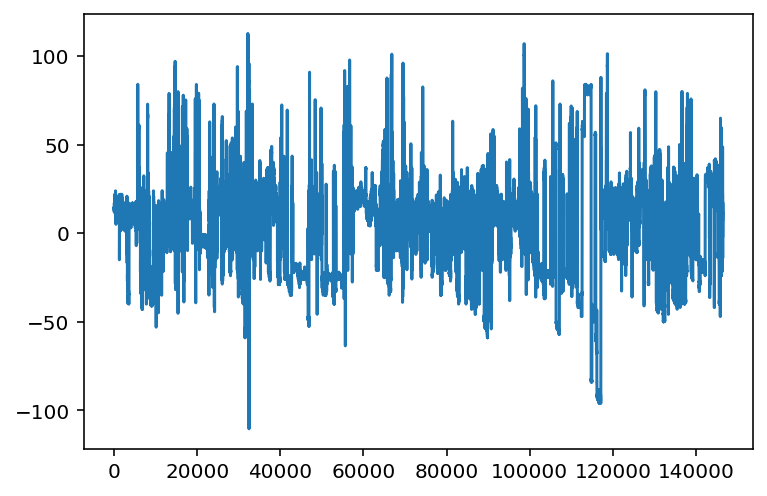

In [142]:
pd.DataFrame(X).loc[:,3].ewm(com=0.1).mean().plot()

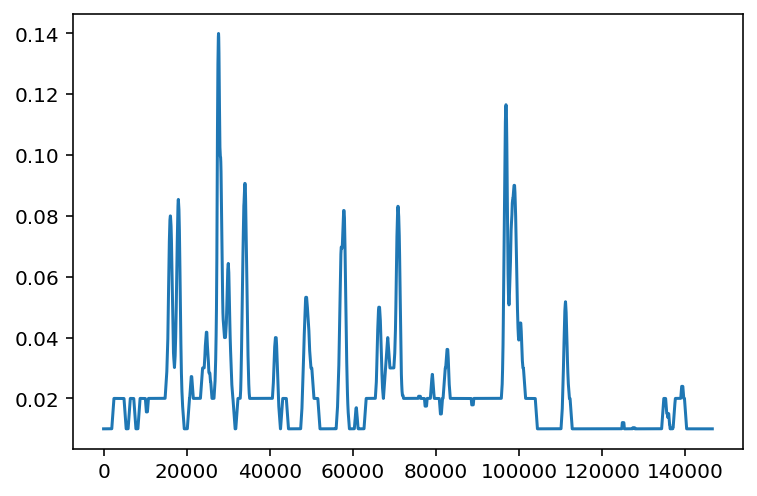

In [168]:
pd.DataFrame(X).loc[:,4].rolling(min_periods=1,window=500).mean().plot()

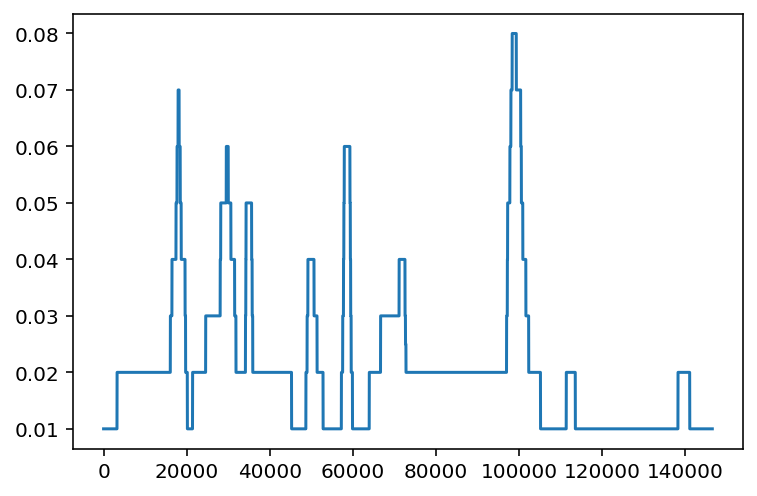

In [169]:
pd.DataFrame(X).loc[:,4].rolling(min_periods=1,window=2500).median().plot()

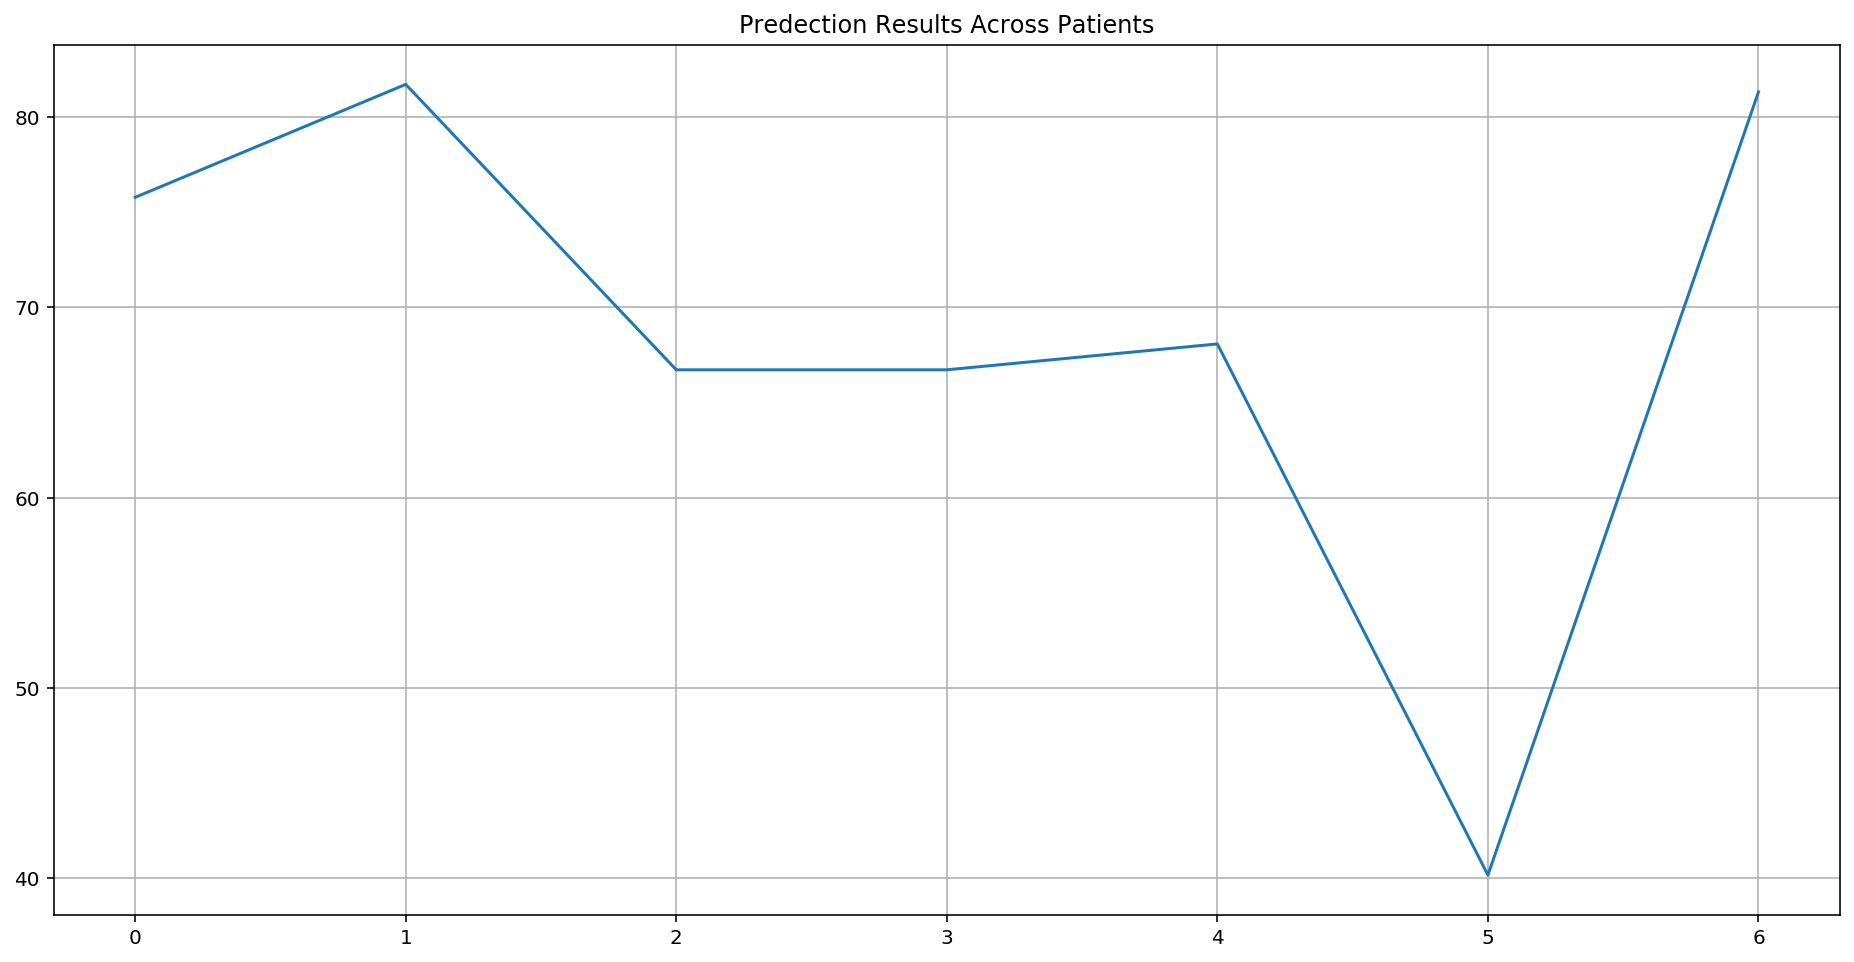

In [248]:
aaa=[75.79,81.73,66.72,66.72,68.08,40.15,81.33]
# columns=['Patient 1','Patient 2','Patient 3','Patient 4','Patient 5','Patient 6','Patient 7']
aaa=pd.DataFrame(data=aaa)

aaa.plot(figsize=(16,8),legend=False,title='Predection Results Across Patients',grid=True)

TRAIN: [    0     1     2 ... 23860 23861 23862] TEST: [23863 23864 23865 ... 47719 47720 47721]


<Figure size 432x288 with 0 Axes>

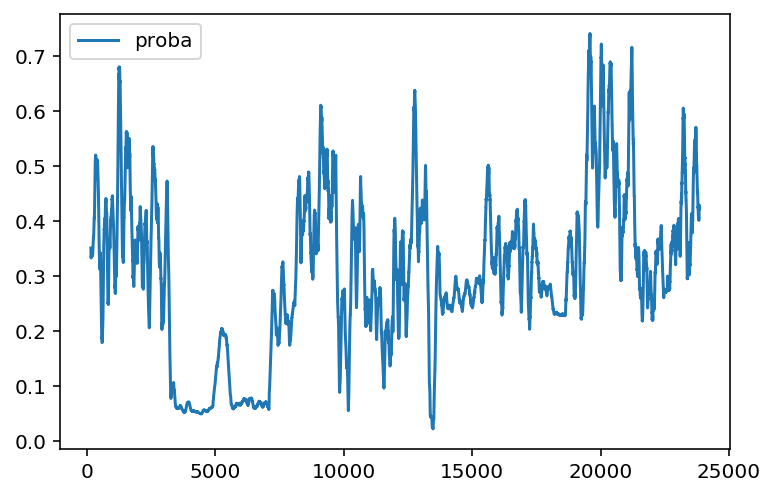

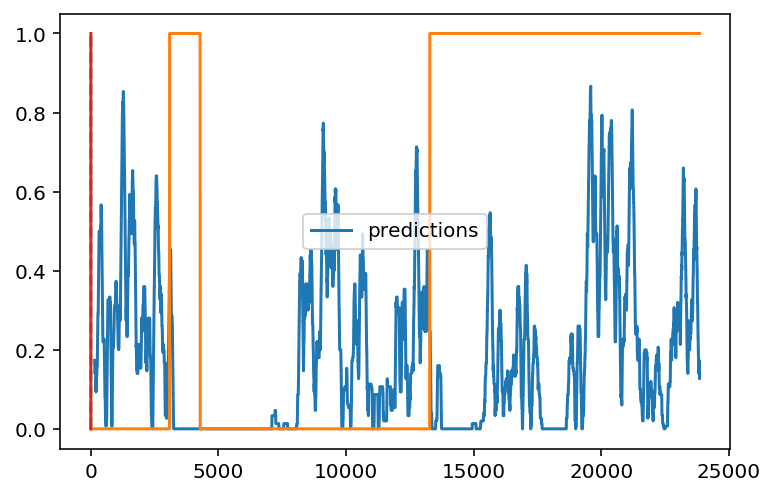


array([[9820, 2262],
       [9738, 2039]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.292666  0.274779  0.204589  0.119742  0.108223        0.0  0.497045   

   true_negative  true_positive  false_positive  false_negative  
0           9820           2039            2262            9738  
TRAIN: [    0     1     2 ... 47719 47720 47721] TEST: [47722 47723 47724 ... 71578 71579 71580]


<Figure size 432x288 with 0 Axes>

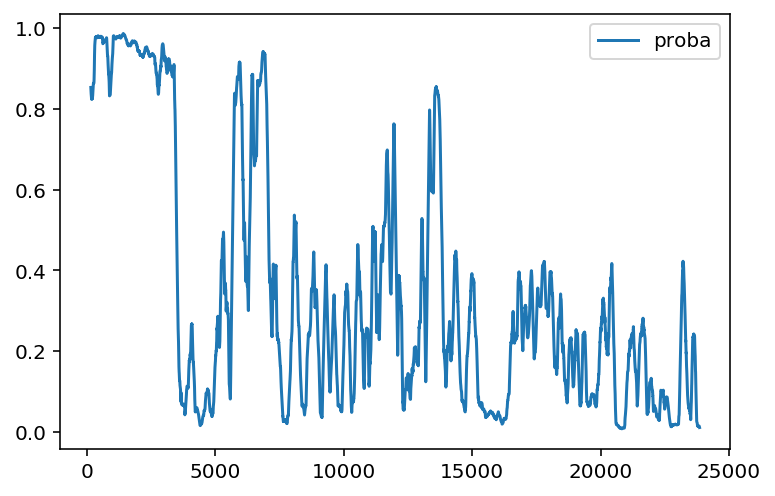

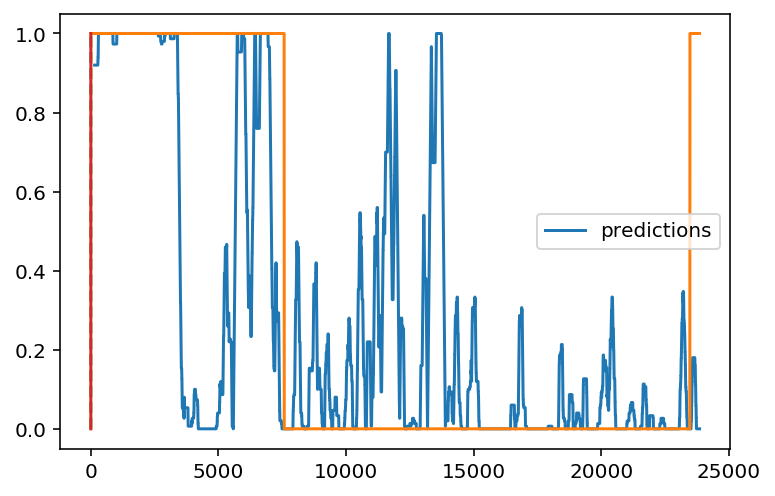


array([[13867,  2033],
       [ 3131,  4828]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.332429  0.264675  0.179266  0.120276  0.103354        0.0  0.783562   

   true_negative  true_positive  false_positive  false_negative  
0          13867           4828            2033            3131  
TRAIN: [    0     1     2 ... 71578 71579 71580] TEST: [71581 71582 71583 ... 95437 95438 95439]


<Figure size 432x288 with 0 Axes>

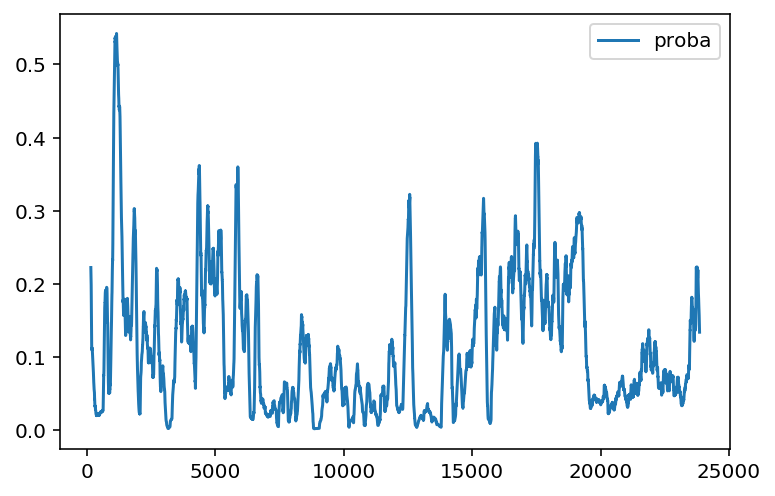

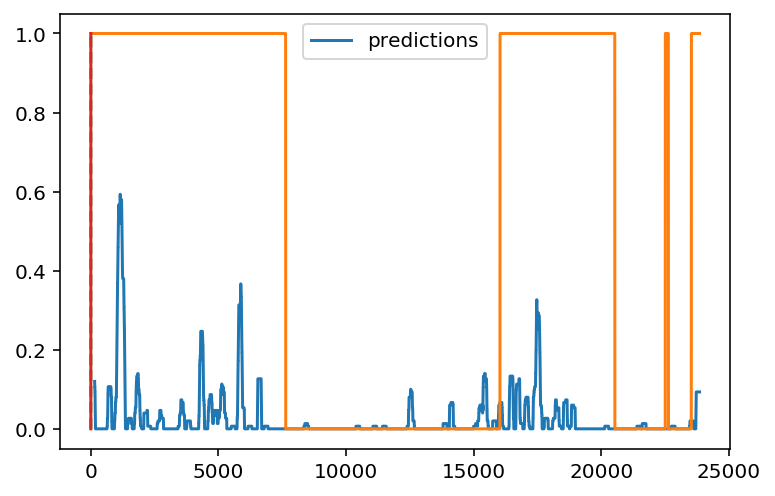


array([[11194,    84],
       [12031,   550]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.372265  0.266377  0.157974  0.107805   0.09558        0.0  0.492225   

   true_negative  true_positive  false_positive  false_negative  
0          11194            550              84           12031  
TRAIN: [    0     1     2 ... 95437 95438 95439] TEST: [ 95440  95441  95442 ... 119296 119297 119298]


<Figure size 432x288 with 0 Axes>

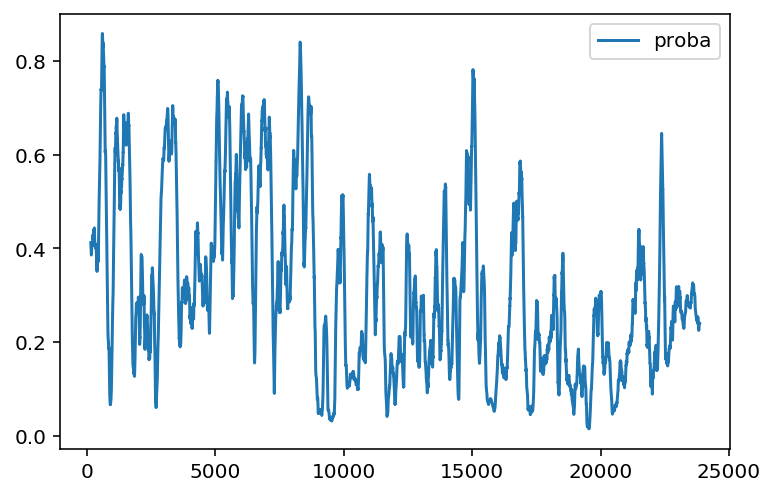

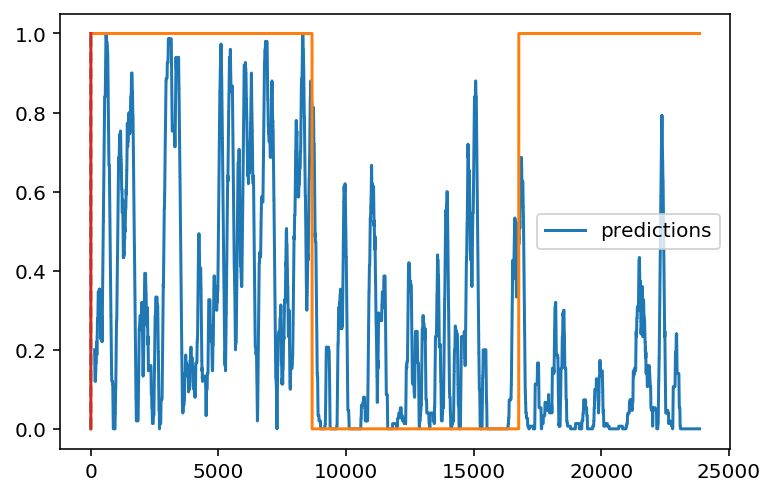


array([[ 6644,  1456],
       [11133,  4626]])
         HR        BR  SkinTemp   Posture  Activity  PeakAccel  Accuracy  \
0  0.343295  0.263213  0.172377  0.119553  0.101561        0.0  0.472358   

   true_negative  true_positive  false_positive  false_negative  
0           6644           4626            1456           11133  
TRAIN: [     0      1      2 ... 119296 119297 119298] TEST: [119299 119300 119301 ... 143155 143156 143157]


<Figure size 432x288 with 0 Axes>

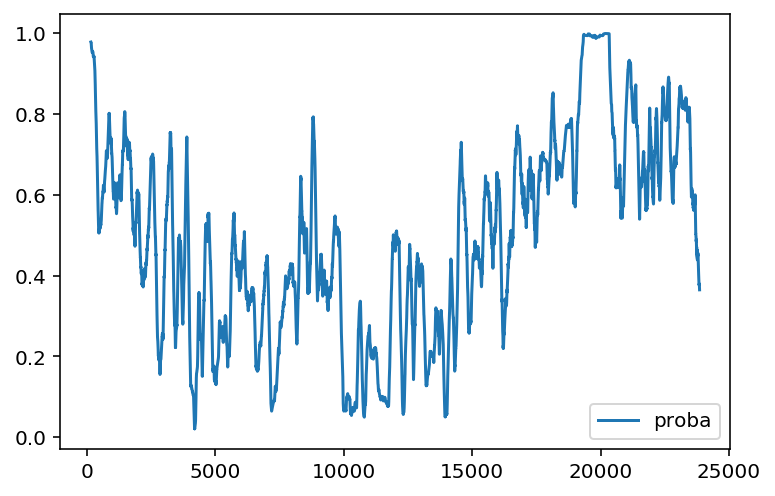

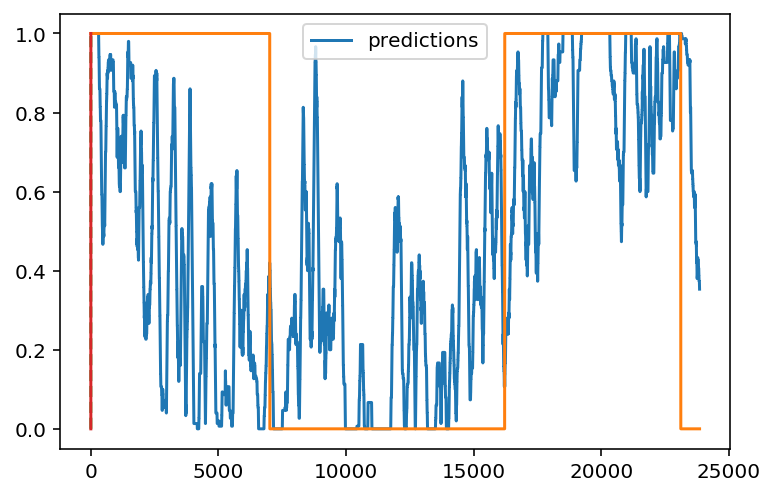


array([[7181, 2766],
       [5172, 8740]])
         HR        BR  SkinTemp  Posture  Activity  PeakAccel  Accuracy  \
0  0.318561  0.264605  0.179983  0.12747  0.109382        0.0  0.667295   

   true_negative  true_positive  false_positive  false_negative  
0           7181           8740            2766            5172  
CPU times: user 10min 39s, sys: 12.9 s, total: 10min 52s
Wall time: 3min 26s


In [194]:
%%time
import warnings
warnings.filterwarnings("ignore")

Results=[]


    
p=Patient_Data(2)
p = p[p.BR<1000].dropna()

dummies=pd.get_dummies(pd.cut(p.glucose,[p.glucose.min(),4,8,p.glucose.max()],labels=['hypo','regular','hyper']))

dummies=dummies.shift(-300).dropna()
p=p.drop(p.tail(300).index)

p.drop(labels=['patientg','glucose', 'glucose_diff','patients','LinkQuality','CoreTemp','SystemConfidence','ECGNoise','StatusInfo',
        'ROGTime','HRConfidence','DeviceTemp','BatteryVolts','BatteryLevel','BRAmplitude','BRNoise','BRConfidence',
       'ECGAmplitude','HRV','GSR','ROGState','VerticalMin', 'VerticalPeak','LateralMin','LateralPeak','SagittalMin',
       'SagittalPeak','RSSI','TxPower','AuxADC1','AuxADC2','AuxADC3'],axis=1,inplace=True)

X=p.values
# X=pd.DataFrame(X).loc[:,:].rolling(min_periods=1,window=500).median().values
# X=pd.DataFrame(X).loc[:,:].rolling(min_periods=1,window=100).mean().values
X=pd.DataFrame(X).loc[:,:].ewm(com=0.9).mean().values
# X=X.values
y=dummies.hyper.values

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Feature Scaling
    from sklearn.preprocessing import QuantileTransformer
    sc = QuantileTransformer(n_quantiles=60, random_state=0)
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    # Fitting classifier to the Training set
    # Create your classifier here
    from sklearn.ensemble import RandomForestClassifier
    classifier1 = RandomForestClassifier(n_estimators = 500, criterion = 'entropy',n_jobs=6)
    classifier1.fit(X_train, y_train)

    # Predicting the Test set results
    y_pred = classifier1.predict(X_test)
    
    from sklearn.metrics import roc_auc_score,roc_curve
    from matplotlib import pyplot
    # predict probabilities
    probs = classifier1.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(y_test, probs)

    plt.figure()
    probability=pd.DataFrame(probs,columns=['proba']).rolling(window=150).mean()
    probability.plot()
    predictions=pd.DataFrame(y_pred,columns=['predictions']).rolling(window=150).mean()
    predictions.plot()
    y_test=pd.DataFrame(y_test,columns=['y_test'])
    plt.plot(y_test)
    
#     plt.plot(y_pred)
    
    # plot no skill
    pyplot.plot([0, 1], [0, 1], linestyle='--')
    # plot the roc curve for the model
    pyplot.plot(fpr, tpr)
    # show the plot
    pyplot.show()

    #Feature Importance
    FI = pd.DataFrame(classifier1.feature_importances_).sort_values(by=0, ascending=False).T
    FI.columns=list(p.columns.values)

    # Making the Confusion Matrix
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_test, y_pred)
    scores=classifier1.score(X_test,y_test)
    FI['Accuracy']=scores
    FI['true_negative']=cm[0,0]
    FI['true_positive']=cm[1,1]
    FI['false_positive']=cm[0,1]
    FI['false_negative']=cm[1,0]
    import pprint
    print ('')
    pprint.pprint (cm)
    pprint.pprint(FI)
#     break
    
    
for i in range(0,len(FI.T)):
    Results.append((FI.iloc[0,i]))
    
score=pd.DataFrame([Results],columns=list(FI.columns))
        
score.to_csv('Model_Results.csv')

data_plot=pd.concat([probability,predictions,y_test],names=['probability','predictions','y_test'],axis=1)
data_plot.to_csv('data_plot.csv')
